# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "11055685"
NAME2 = "10669124"
EMAIL = "ozzy.ulger@gmail.com"
EMAIL2 = "lucstefelmanns@live.nl"

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

Install nb_conda with version 2.2.1 or newer, it is required for this assignment!


In [4]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$.


In [5]:
# Generate vectors x (coordinates of samples) and t (sampled datapoints from sin(x) with noise)
def gen_sine(n):
    x = np.linspace(0, 2*np.pi, n, endpoint=True)
    mu = np.sin(x)
    t = np.random.normal(mu, 0.25)
    return x, t

In [6]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [7]:
# Make the designmatrix (Eq. 3.16 Bishop)
def designmatrix(x, M):

    # Set design matrix size N x (M+1)
    Phi = np.zeros((len(x), M + 1))

    # Iterate through Phi
    for i in range(len(x)):
        for j in range(M + 1):

            # Fill with jth power of x[i]
            Phi[i][j] = x[i] ** j

    return Phi

# Derive the maximum likelihood of w and return it with Phi
def fit_polynomial(x, t, M):
    Phi = designmatrix(x, M)

    # Compute unregularized w_ml (Eq. 3.15 Bishop)
    w_ml = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t

    return w_ml, Phi

In [8]:
### Test your function
N = 10
x = np.square((np.linspace(-1, 1, N)))
t = 0.3*x + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

In [29]:
# Plot the fitted polynomial
def plot_fitted(x, t, func, func_name, M_vals, reg=None):
    x_new = np.linspace(0, 2*np.pi, 1000, endpoint=True)
    for i in M_vals:
        lambda_legend = ""
        if reg:
            w, Phi = fit_polynomial_reg(x, t, i, reg)
            plt.title('Regularized linear regression')
            lambda_legend += ", lambda = e^" + str(round(np.log(reg), 2))
        else:
            plt.title('Unregularized linear regression')
            w, Phi = fit_polynomial(x, t, i)

        # Estimated values
        est = Phi @ w

        # Interpolate on bigger range on x axis (x_new)
        i_est = interp1d(x, est, bounds_error=False, kind='cubic')
        plt.plot(x_new, i_est(x_new), label="M = " + str(i) + lambda_legend)

    i_func = interp1d(x, func, kind='cubic')
    plt.plot(x_new, i_func(x_new), 'black', label=func_name, linewidth=3)
    plt.plot(x, t, 'o', label='Observed datapoints', color='black', mfc='none')
    
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.rcParams["figure.figsize"] = [18,9]
    plt.xlim(xmin=0, xmax=2*np.pi)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.grid(color='lightgrey')
    plt.show()

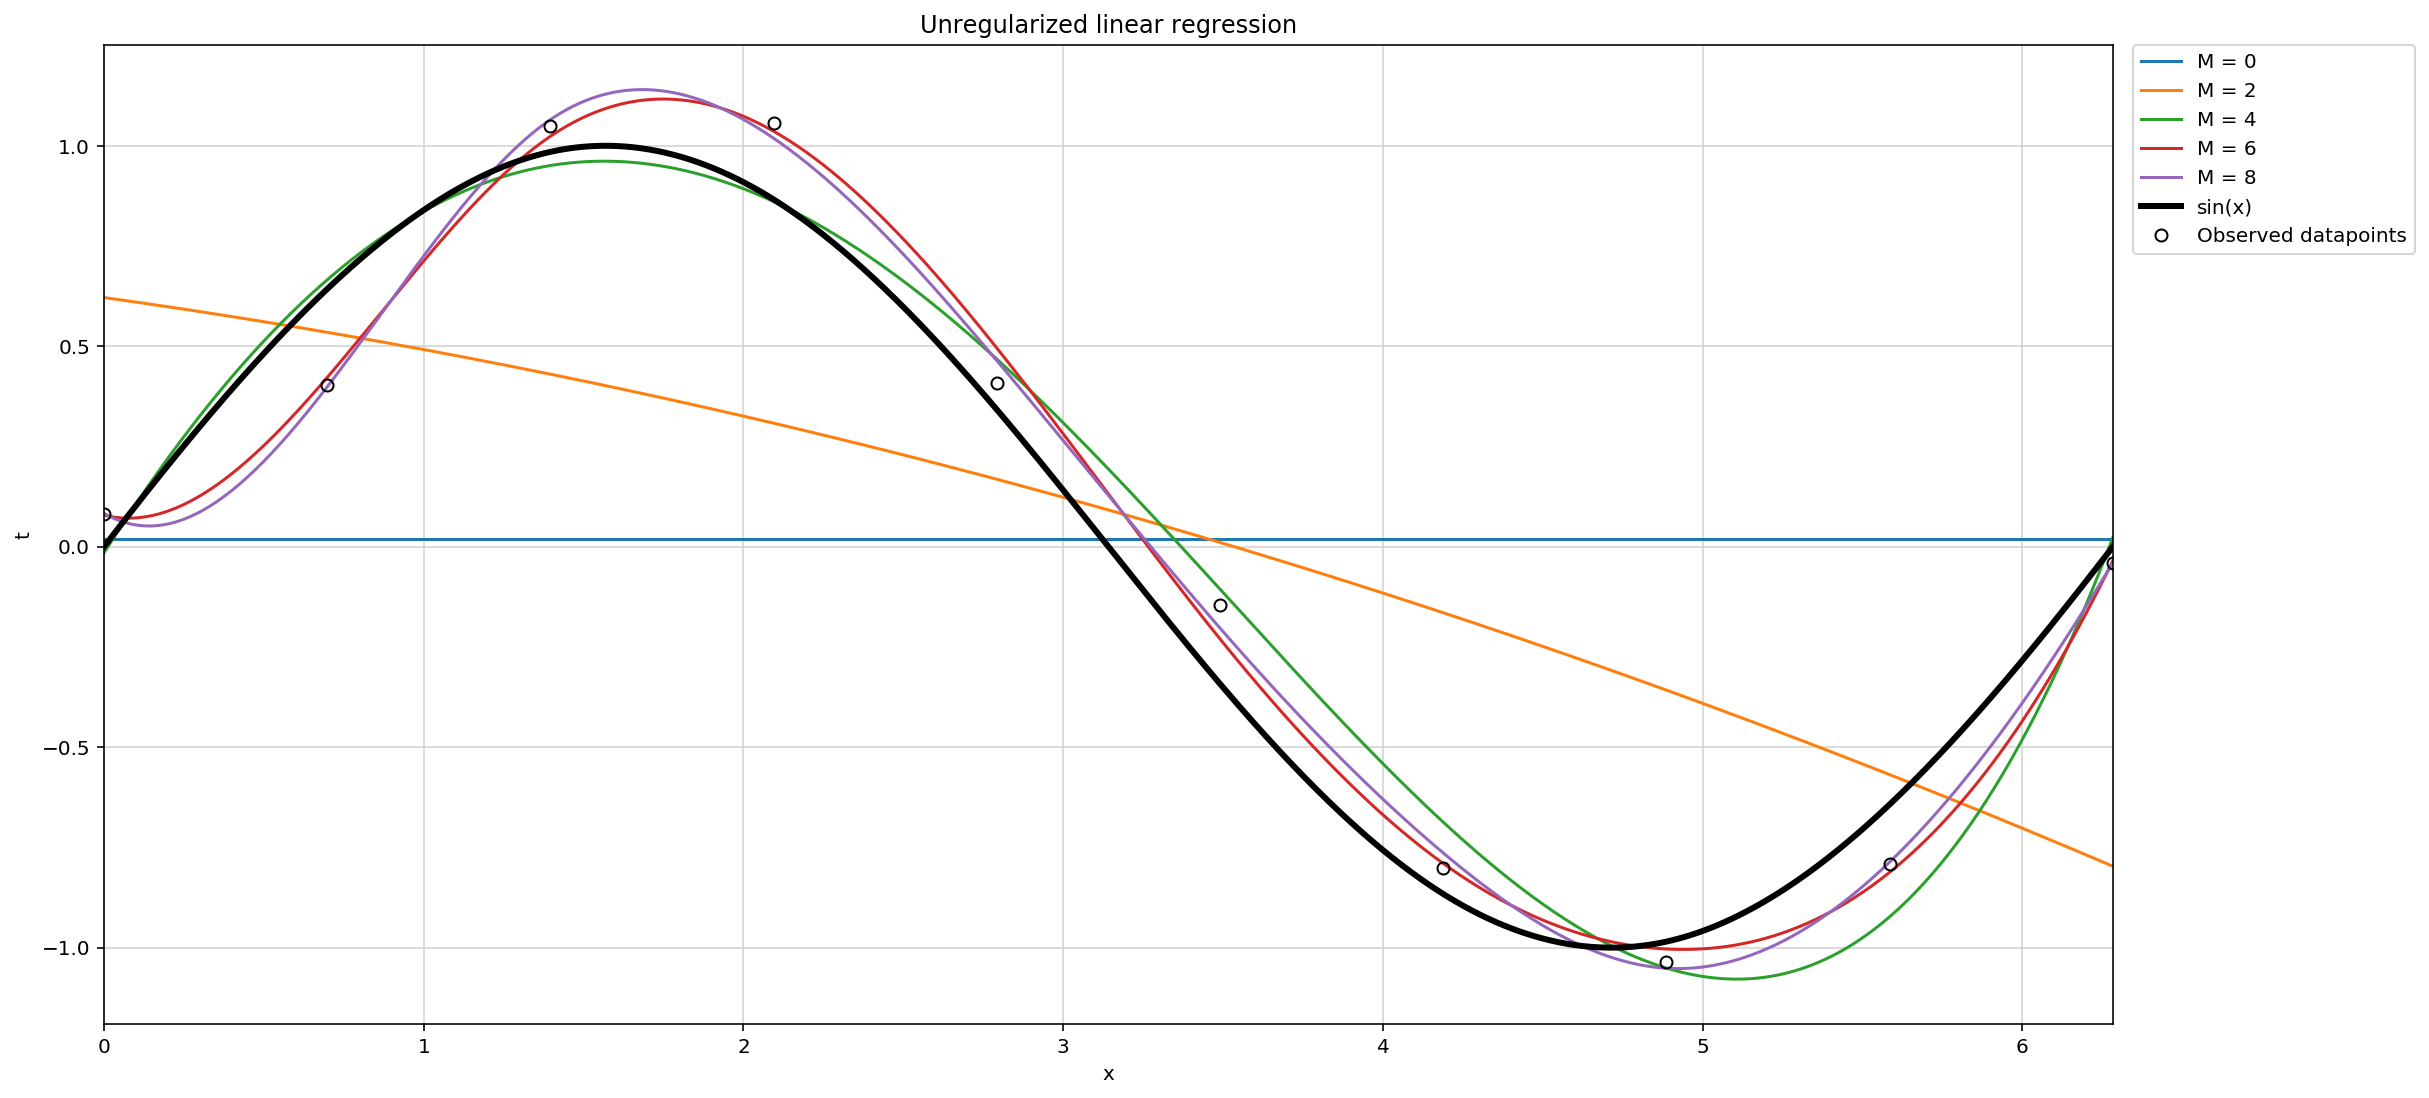

In [30]:
x, t = gen_sine(10)
M_vals = [M for M in range(0, 10, 2)]
plot_fitted(x, t, sin(x), "sin(x)", M_vals)

### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [11]:
# Derive the regularized maximum likelihood of w and return it with Phi
def fit_polynomial_reg(x, t, m, lamb):

    # The designmatrix Phi
    Phi = designmatrix(x, m)

    # lambda*I
    I_lamb = np.diag(np.repeat(lamb, m+1))

    # Compute regularized w_ml (Eq. 3.28 Bishop)
    w_ml = np.linalg.inv(I_lamb + Phi.T @ Phi) @ Phi.T @ t

    return w_ml, Phi

In [12]:
### Test your function
N = 10
x = np.square((np.linspace(-1, 1, N)))
t = 0.3*x + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x + 2.5$)

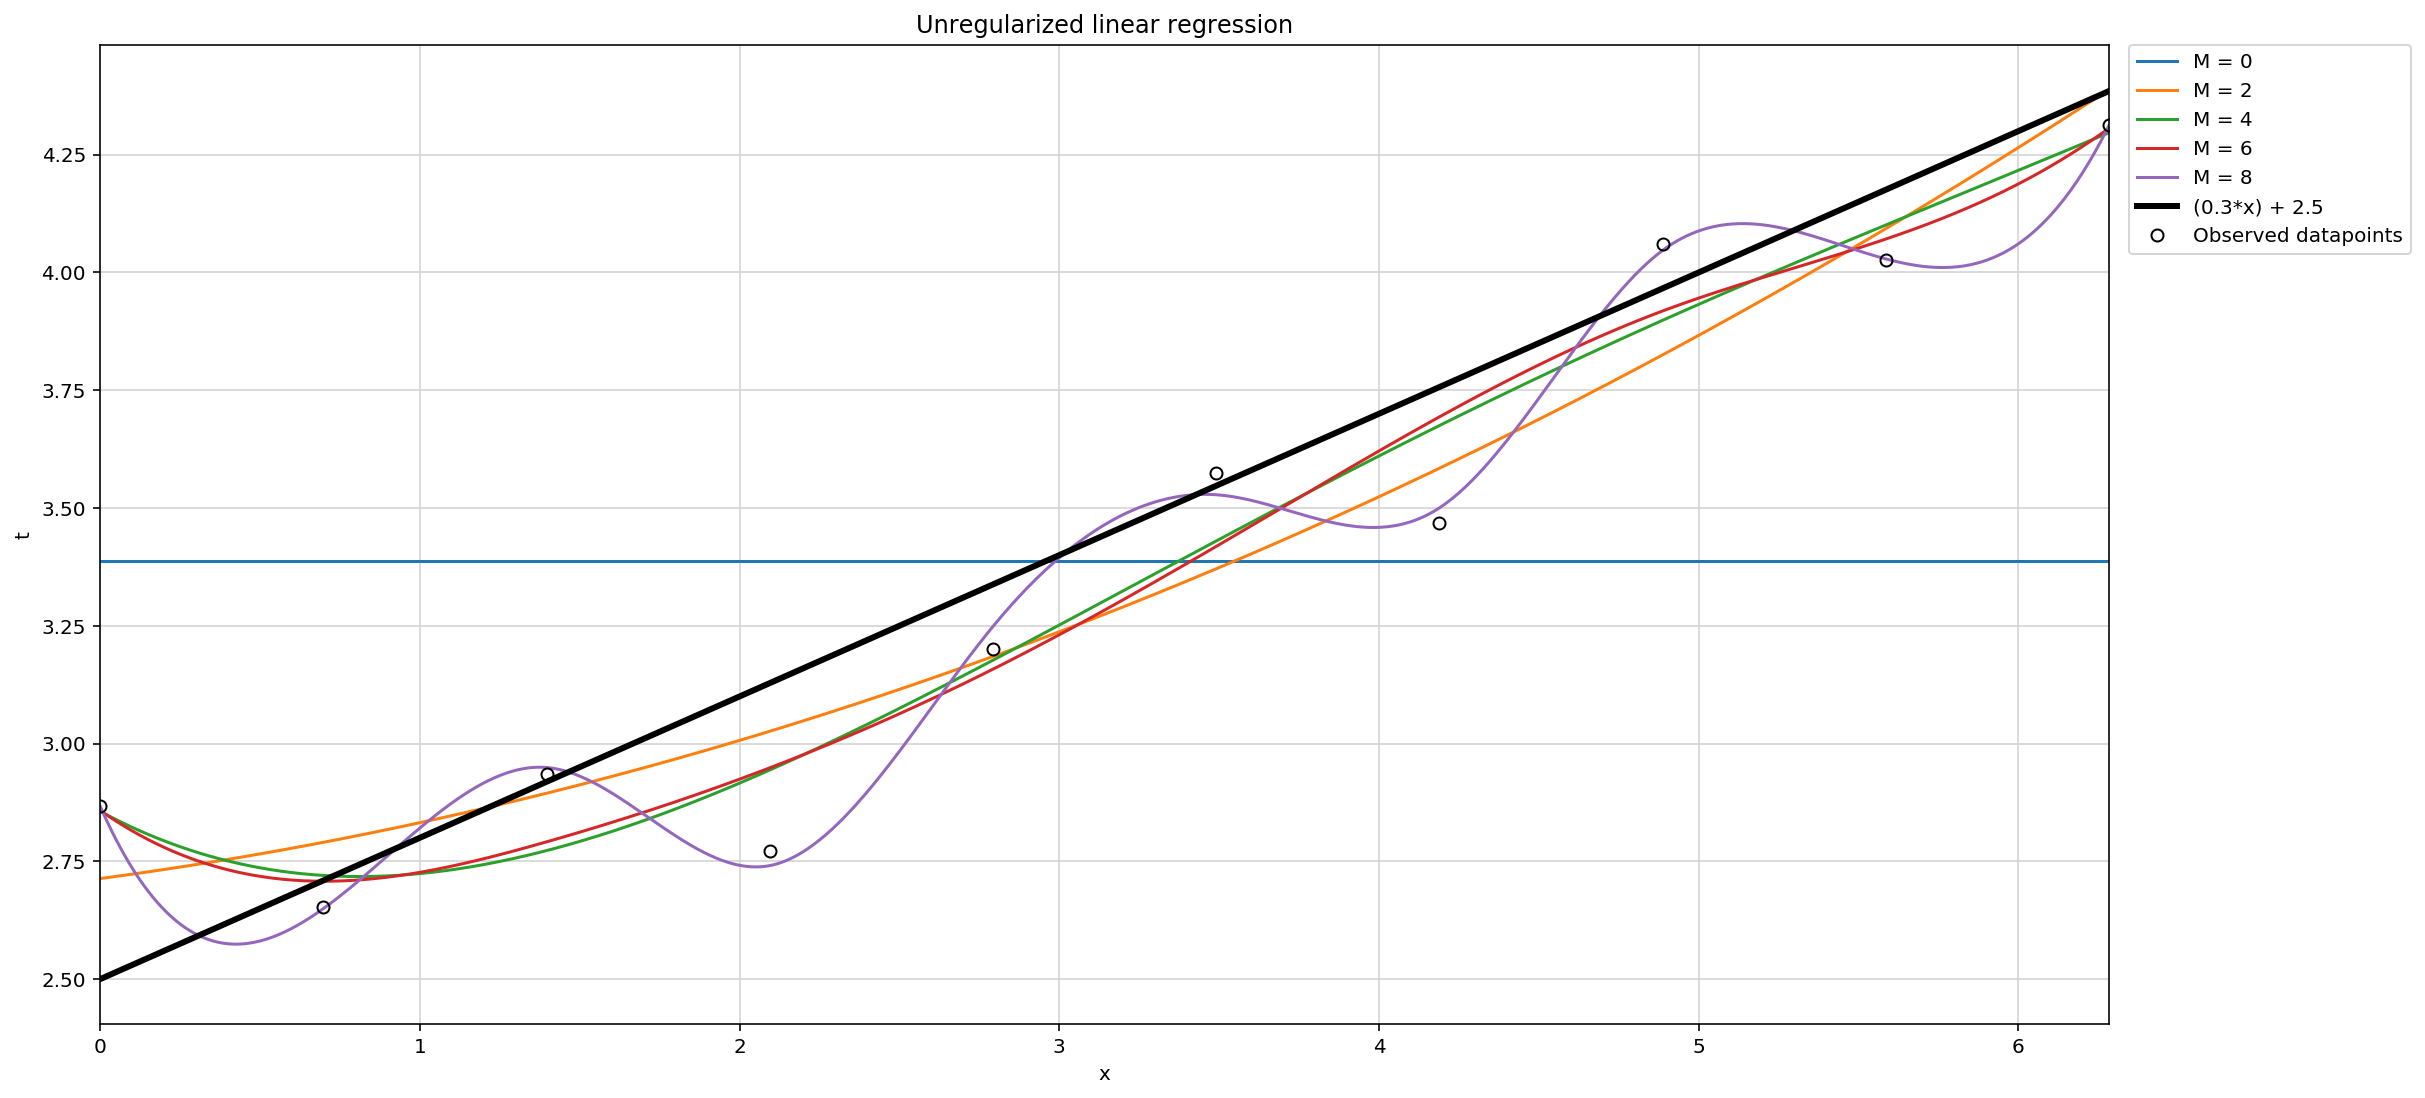

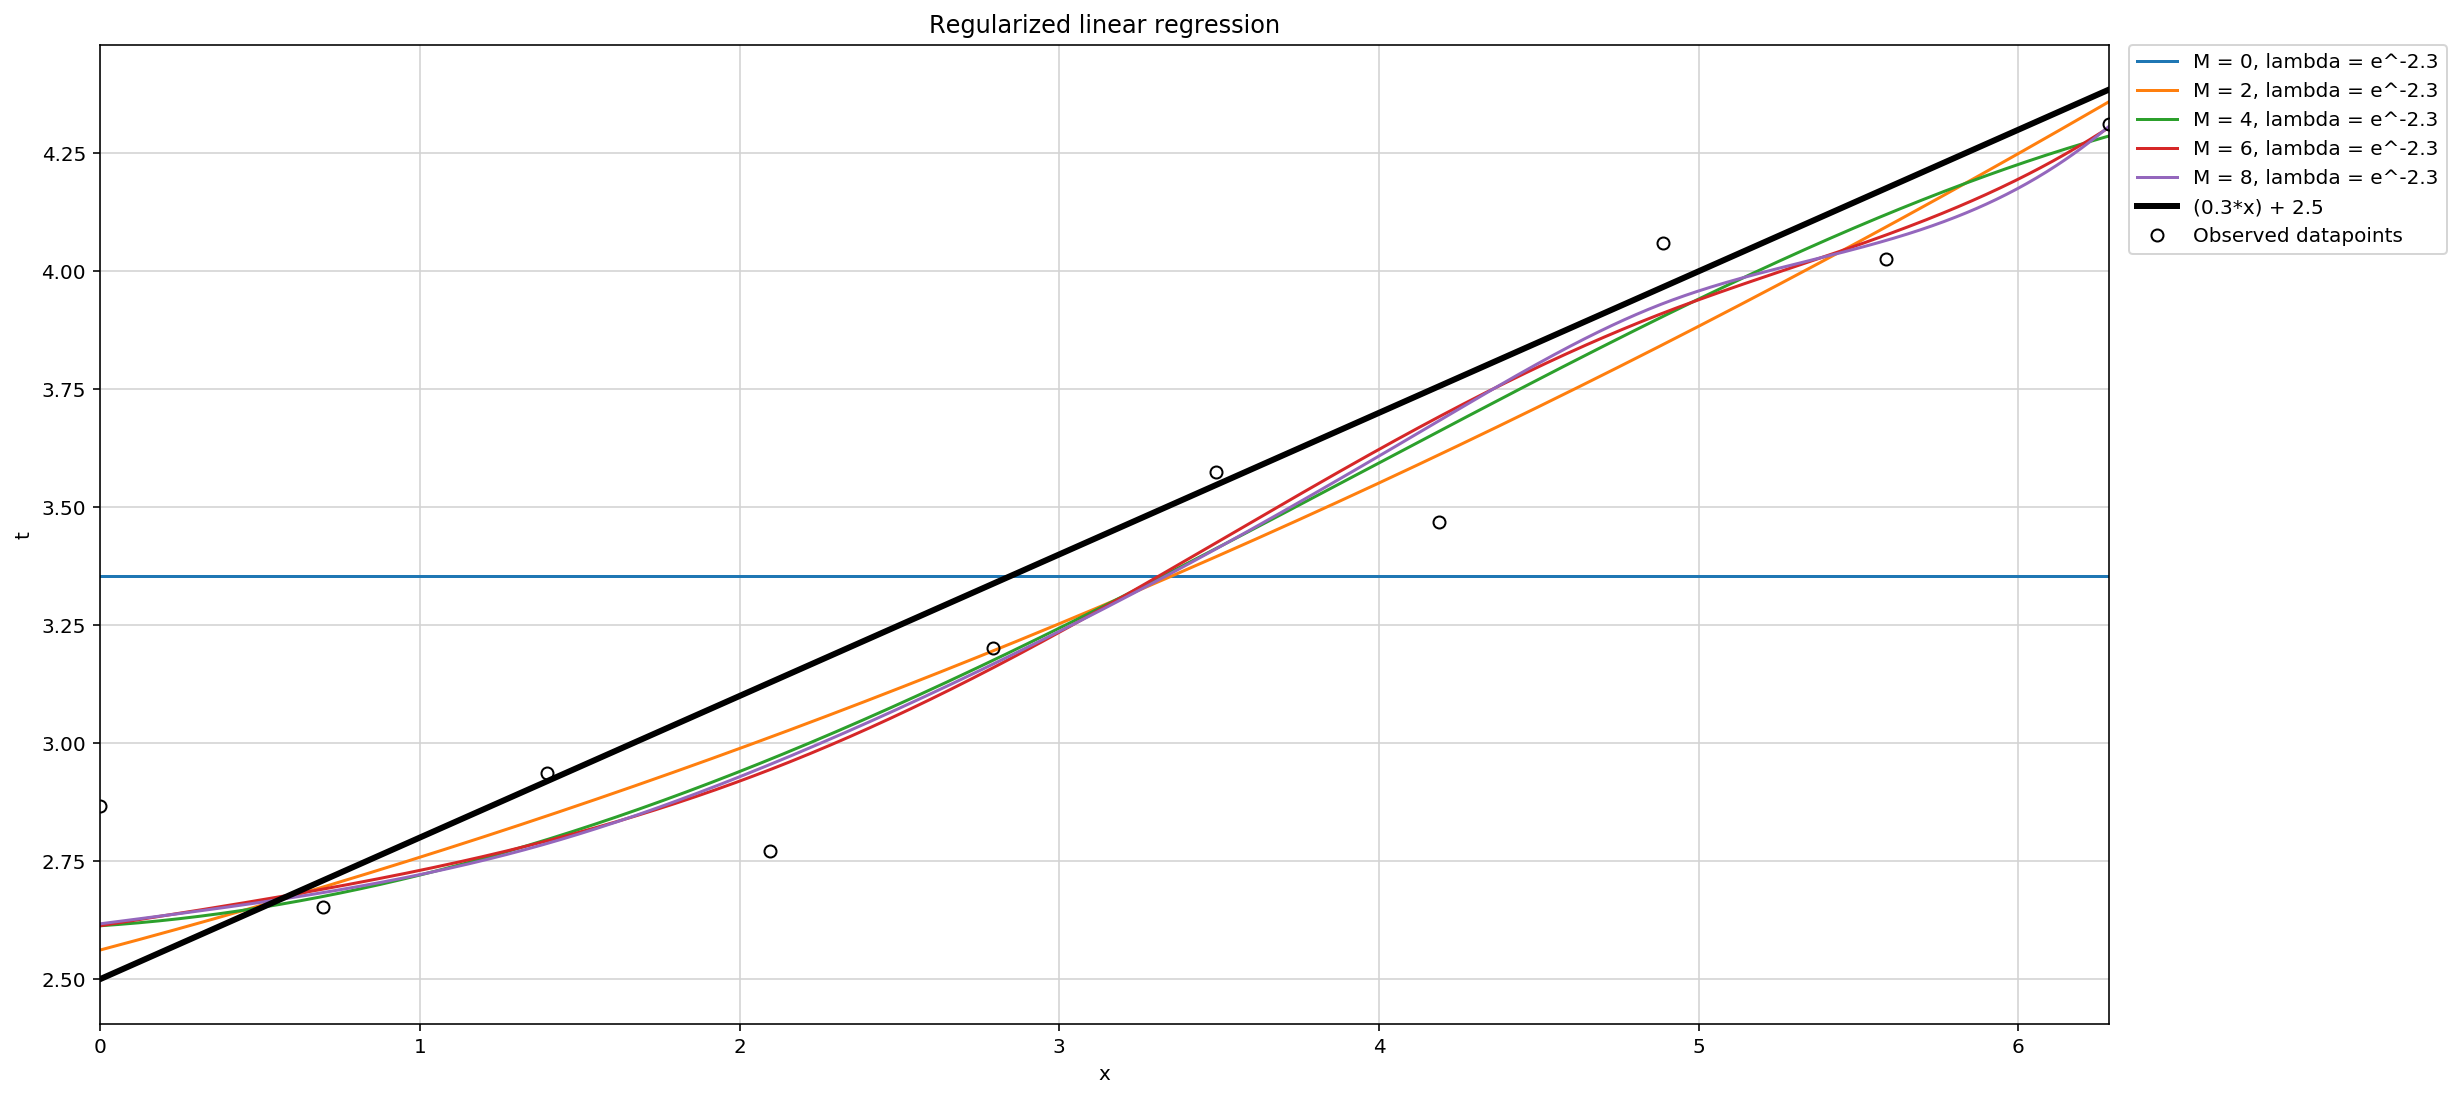

In [13]:
x = np.linspace(0, 2*np.pi, 10, endpoint=True)
mu = (0.3*x) + 2.5
t = np.random.normal(mu, 0.25)
np.random.seed(4)
plot_fitted(x, t, mu, "(0.3*x) + 2.5", M_vals)
plot_fitted(x, t, mu, "(0.3*x) + 2.5", M_vals, 0.1)

Phi stays the same, since it is independent of the regularization. w_ml is influenced by the regularization by penalizing higher values, resulting in functions of lower complexity. This can be observed in the plots above, since the regularized graphs are straighter and less complex compared to the unregularized ones. This is especially evident for higher-order polynomials, as can be seen from the purple graph.






### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [14]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):

    # Fit the polynomial on the train data
    w, _ = fit_polynomial_reg(x_train, t_train, M, reg)
    t_pred = []

    # Predict values of t_valid by w.T*phi(x)
    for x in x_valid:
        single_t_pred = 0
        for i in range(M+1):
            single_t_pred += (x**i) * w[i]
        t_pred.append(single_t_pred)

    # Sum of squares error: [t - w.T*phi(x)]^2 
    pred_err = (1/2) * np.sum((t_valid - t_pred)**2)
    return pred_err

In [15]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [16]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [17]:
def find_best_m_and_lamb(x, t):
    train_folds, valid_folds = kfold_indices(len(x), 5)

    # Get the corresponding x and t train-values of indexes of the fold
    x_folds_train = np.array([[x[index] for index in train_fold] for train_fold in train_folds])
    t_folds_train = np.array([[t[index] for index in train_fold] for train_fold in train_folds])

    # Get the corresponding x and t test-values of indexes of the fold
    x_folds_test = np.array([[x[index] for index in test_fold] for test_fold in valid_folds])
    t_folds_test = np.array([[t[index] for index in test_fold] for test_fold in valid_folds])

    # Get all input combinations of M and lambda
    M = np.arange(0, 11)
    lamb = np.exp(np.arange(-10, 1))
    combinations = [(m,l) for m in M for l in lamb]

    # Get all prediction errors of all (M, lambda) possibilities
    combination_errors = [np.average([pred_error(x_tr, x_te, t_tr, t_te, mth, reg)
                          for x_tr, x_te, t_tr, t_te
                          in zip(x_folds_train, x_folds_test, t_folds_train, t_folds_test)])
                         for (mth,reg) in combinations
                         ]
    
    # Get index of (M, lambda) combination with minimum average cross-validation error
    best_index = combination_errors.index(min(combination_errors))
    M_best = combinations[best_index][0]
    lamb_best = combinations[best_index][1]
    return M_best, lamb_best

x, t = gen_sine(10)
best_m, best_l = find_best_m_and_lamb(x, t)
print("The best m is {:.0f}, and the best lambda is e^{:.0f}".format(best_m, np.log(best_l)))

The best m is 5, and the best lambda is e^-2


In [18]:
### If you want you can write your own test here

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

Because the optimal regularization coefficient ($\lambda$) is dependent on the order of the polynomial ($M$), we must use grid search in this case to find the optimal combination of parameter values.

If the parameters are dependent and we optimize them in a sequental way, we would only evaluate a subset of the possible combinations of $M$ and $\lambda$. The dependency relationship between these parameters, however, means that if the optimal combination of the parameters is not in this subset, it will most likely not be found.

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

Evolutionary optimization. This method avoids the combinatorial explosion because the amount of combinations considered is restricted to the population size times the amount of generations the user chooses, instead of $2^{n\_parameters}$. Generally, the algorithm converges relatively fast to an optimal solution and therefore is not as expensive as grid search.

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

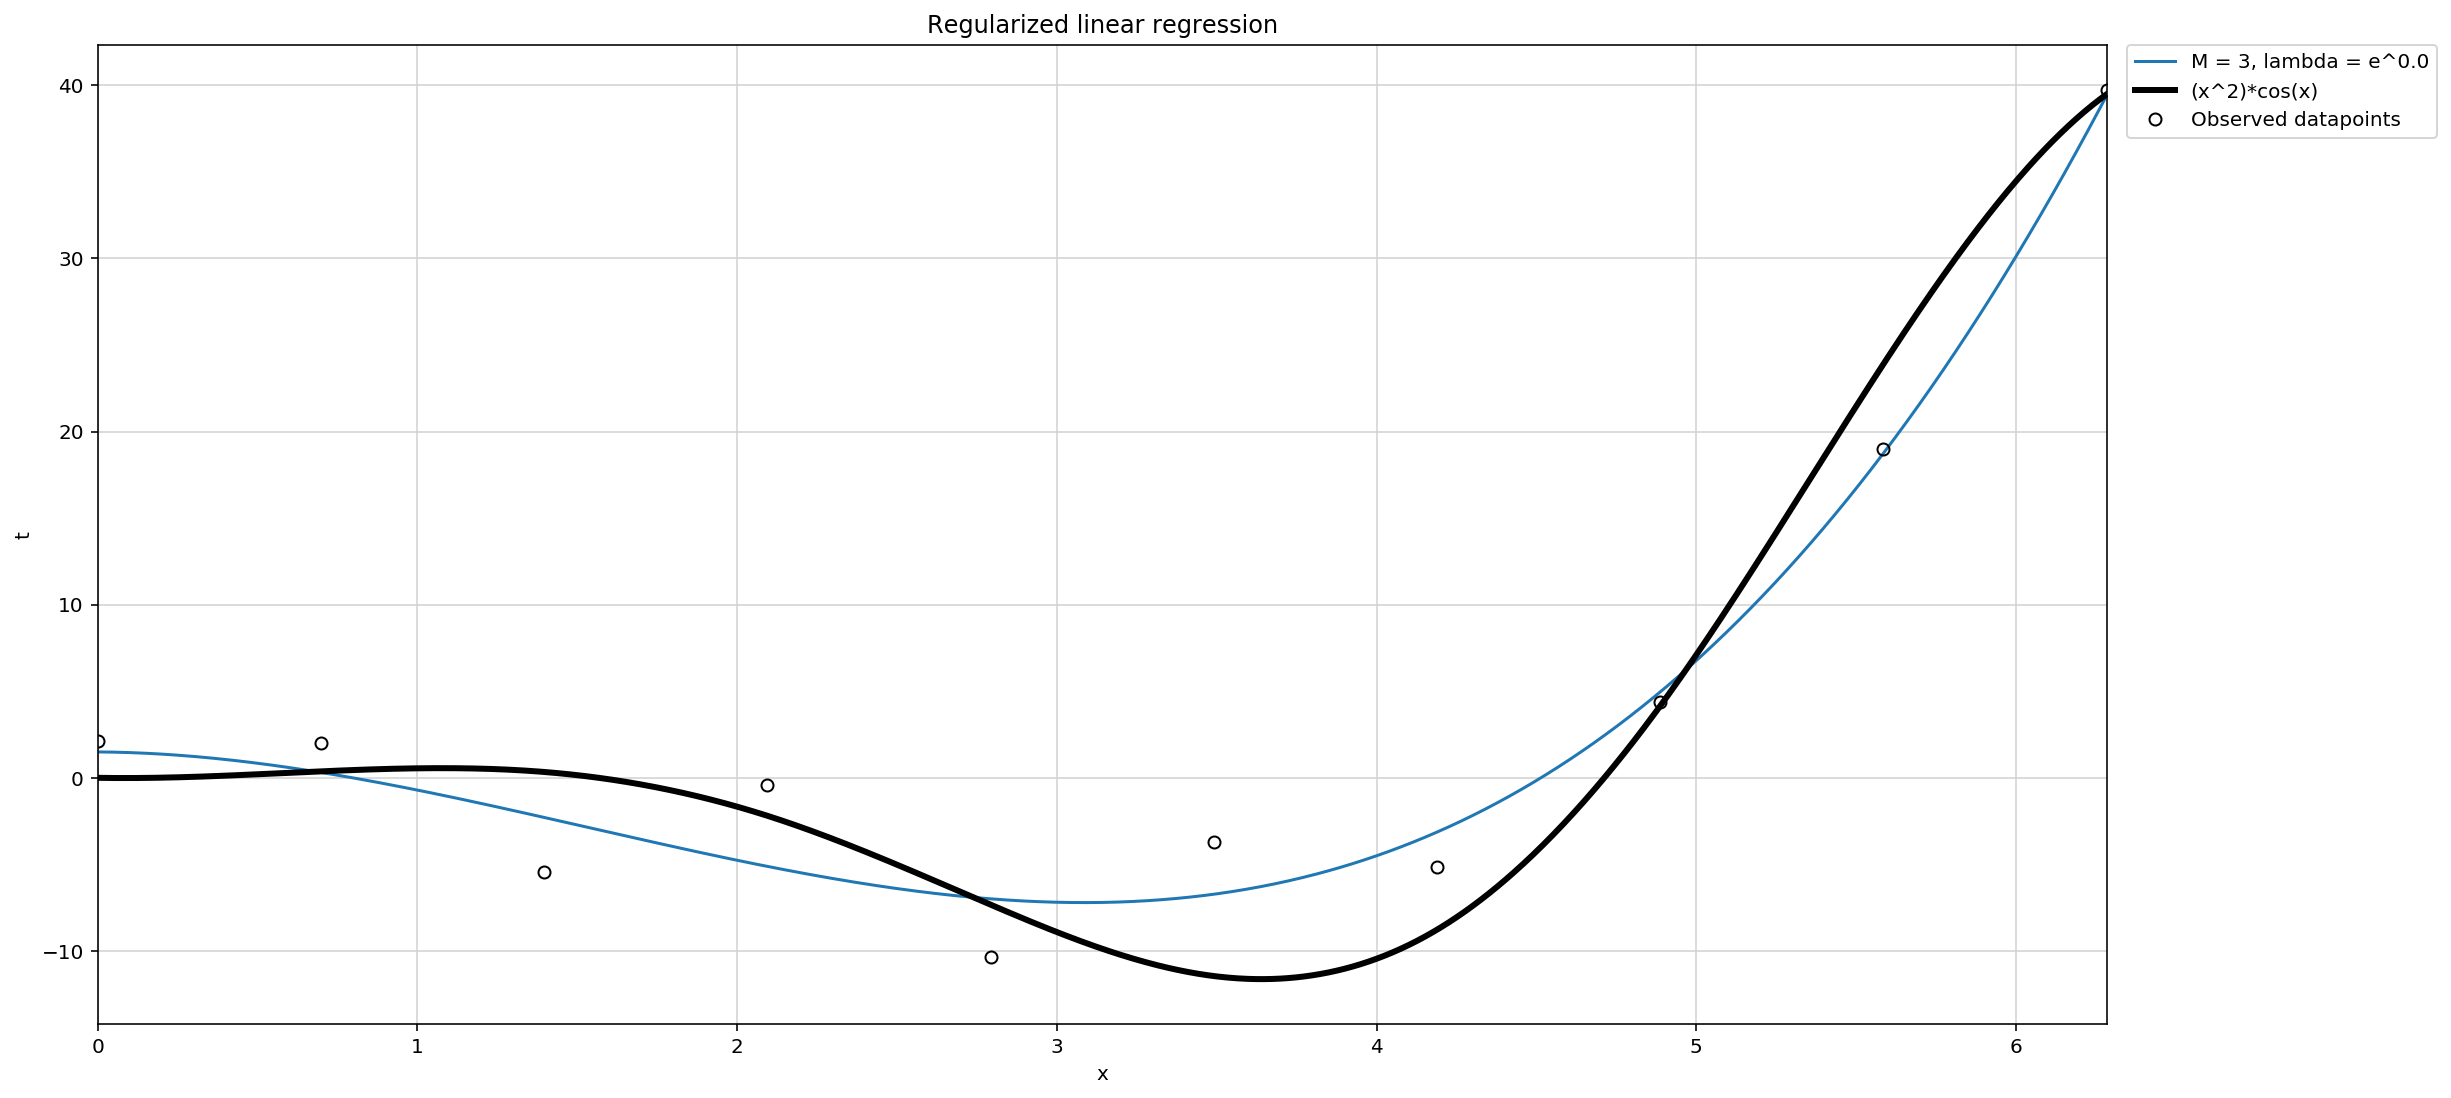

In [19]:
N = 10
sigma = 5
x = np.linspace(0, 2*np.pi, N, endpoint=True)
mu = (x**2)*cos(x)
t = np.random.normal(mu, sigma, N)

M_best, lamb_best = find_best_m_and_lamb(x, t)

plot_fitted(x, t, mu, "(x^2)*cos(x)", [M_best], lamb_best)

The best M and lambda found can be observed in the legend for the blue line.

## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [20]:
# Generate vectors x (coordinates of samples) and t (sampled datapoints from sin(x) with noise)
def gen_sine2(n):
    x = np.sort(np.random.uniform(0, 2*np.pi, n))
    mu = np.sin(x)
    t = np.random.normal(mu, 0.25)
    return x, t

In [21]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [22]:
# Derive the maximum a posteriori of w and return it with the covariance matrix and Phi
def fit_polynomial_bayes(x, t, M, alpha, beta):
    Phi = designmatrix(x, M)
    I = np.identity(M + 1)
    
    # Compute covariance of posterior (Eq. 3.54 Bishop)
    S = np.linalg.inv(alpha * I + beta * np.matmul(Phi.T, Phi))
    
    # Compute mean of posterior (Eq. 3.53 Bishop)
    m = beta * S @ Phi.T @ t    
    return m, S, Phi

In [23]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [24]:
# Calculate the predictive mean, variance for every new datapoint and return it with Phi
def predict_polynomial_bayes(x, m, S, beta):
    Phi = designmatrix(x, len(m)-1)
    mean = np.zeros(len(x))
    sigma = np.zeros(len(x))
    for i in range(len(x)):
        
        # Compute vector of Mth order polynomial per new datapoint
        phi = np.array([x[i] ** j for j in range(len(m))])
        
        # Compute predictive mean per new datapoint (Eq. 3.58 Bishop)
        mean[i] = m @ phi
        
        # Compute predictive covariance per new datapoint (Eq. 3.59 Bishop)
        sigma[i] = (1 / beta) + phi.T @ S @ phi
    return mean, sigma, Phi

In [25]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and a 1-sigma predictive variance using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


In [26]:
# Plot the predictive/posterior distribution
def plot_predictive(x, t, m, S, beta, func, func_name, multi=False):
    x_new = np.linspace(0, 2*np.pi, 1000, endpoint=True)
    plt.grid(color='lightgrey')
    plt.plot(x, t, 'o', label='Observed datapoints', color='red', mfc='none')

    # For multiple samples
    if multi:
        plt.title('100 polynomials of 100 samples from the parameters posterior distribution \n M = '\
                  + str(len(m) - 1) + ', alpha = ' + str(alpha) + ', beta = ' + str(beta))
        
        # Draw 100 samples from parameter's post. distr. using a multivariate Gaussian 
        for c, i in enumerate(np.random.multivariate_normal(m, S, 100)):
            mean, sigma, Phi = predict_polynomial_bayes(x, i, S, beta)
            i_mean = interp1d(x, mean, bounds_error=False, kind='cubic')
            
            # Plot once with label for the legend
            if c == 0:
                plt.plot(x_new, i_mean(x_new), color='grey', alpha=0.3, label="Sample of post. distr.")
            else:
                plt.plot(x_new, i_mean(x_new), color='grey', alpha=0.2)
    
    # For one predictive distribution
    else:
        plt.title('Predictive distribution\n M = ' + str(len(m) - 1) + ', alpha = ' + str(alpha) + \
                  ', beta = ' + str(beta))
        mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)
        i_mean = interp1d(x, mean, bounds_error=False, kind='cubic')
        i_lower = interp1d(x, mean - np.sqrt(sigma), bounds_error=False, kind='cubic')
        i_upper = interp1d(x, mean + np.sqrt(sigma), bounds_error=False, kind='cubic')
        plt.plot(x_new, i_mean(x_new), label='Predictive mean')
        plt.fill_between(x_new, i_lower(x_new), i_upper(x_new), color='gray', alpha=0.2, 
                         label='Predictive variance')

    i_func = interp1d(x, func, bounds_error=False, kind='cubic')

    plt.plot(x_new, i_func(x_new), 'red', label=func_name, linewidth=3)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.rcParams["figure.figsize"] = [18,9]
    plt.xlim(xmin=0, xmax=2*np.pi)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.show()

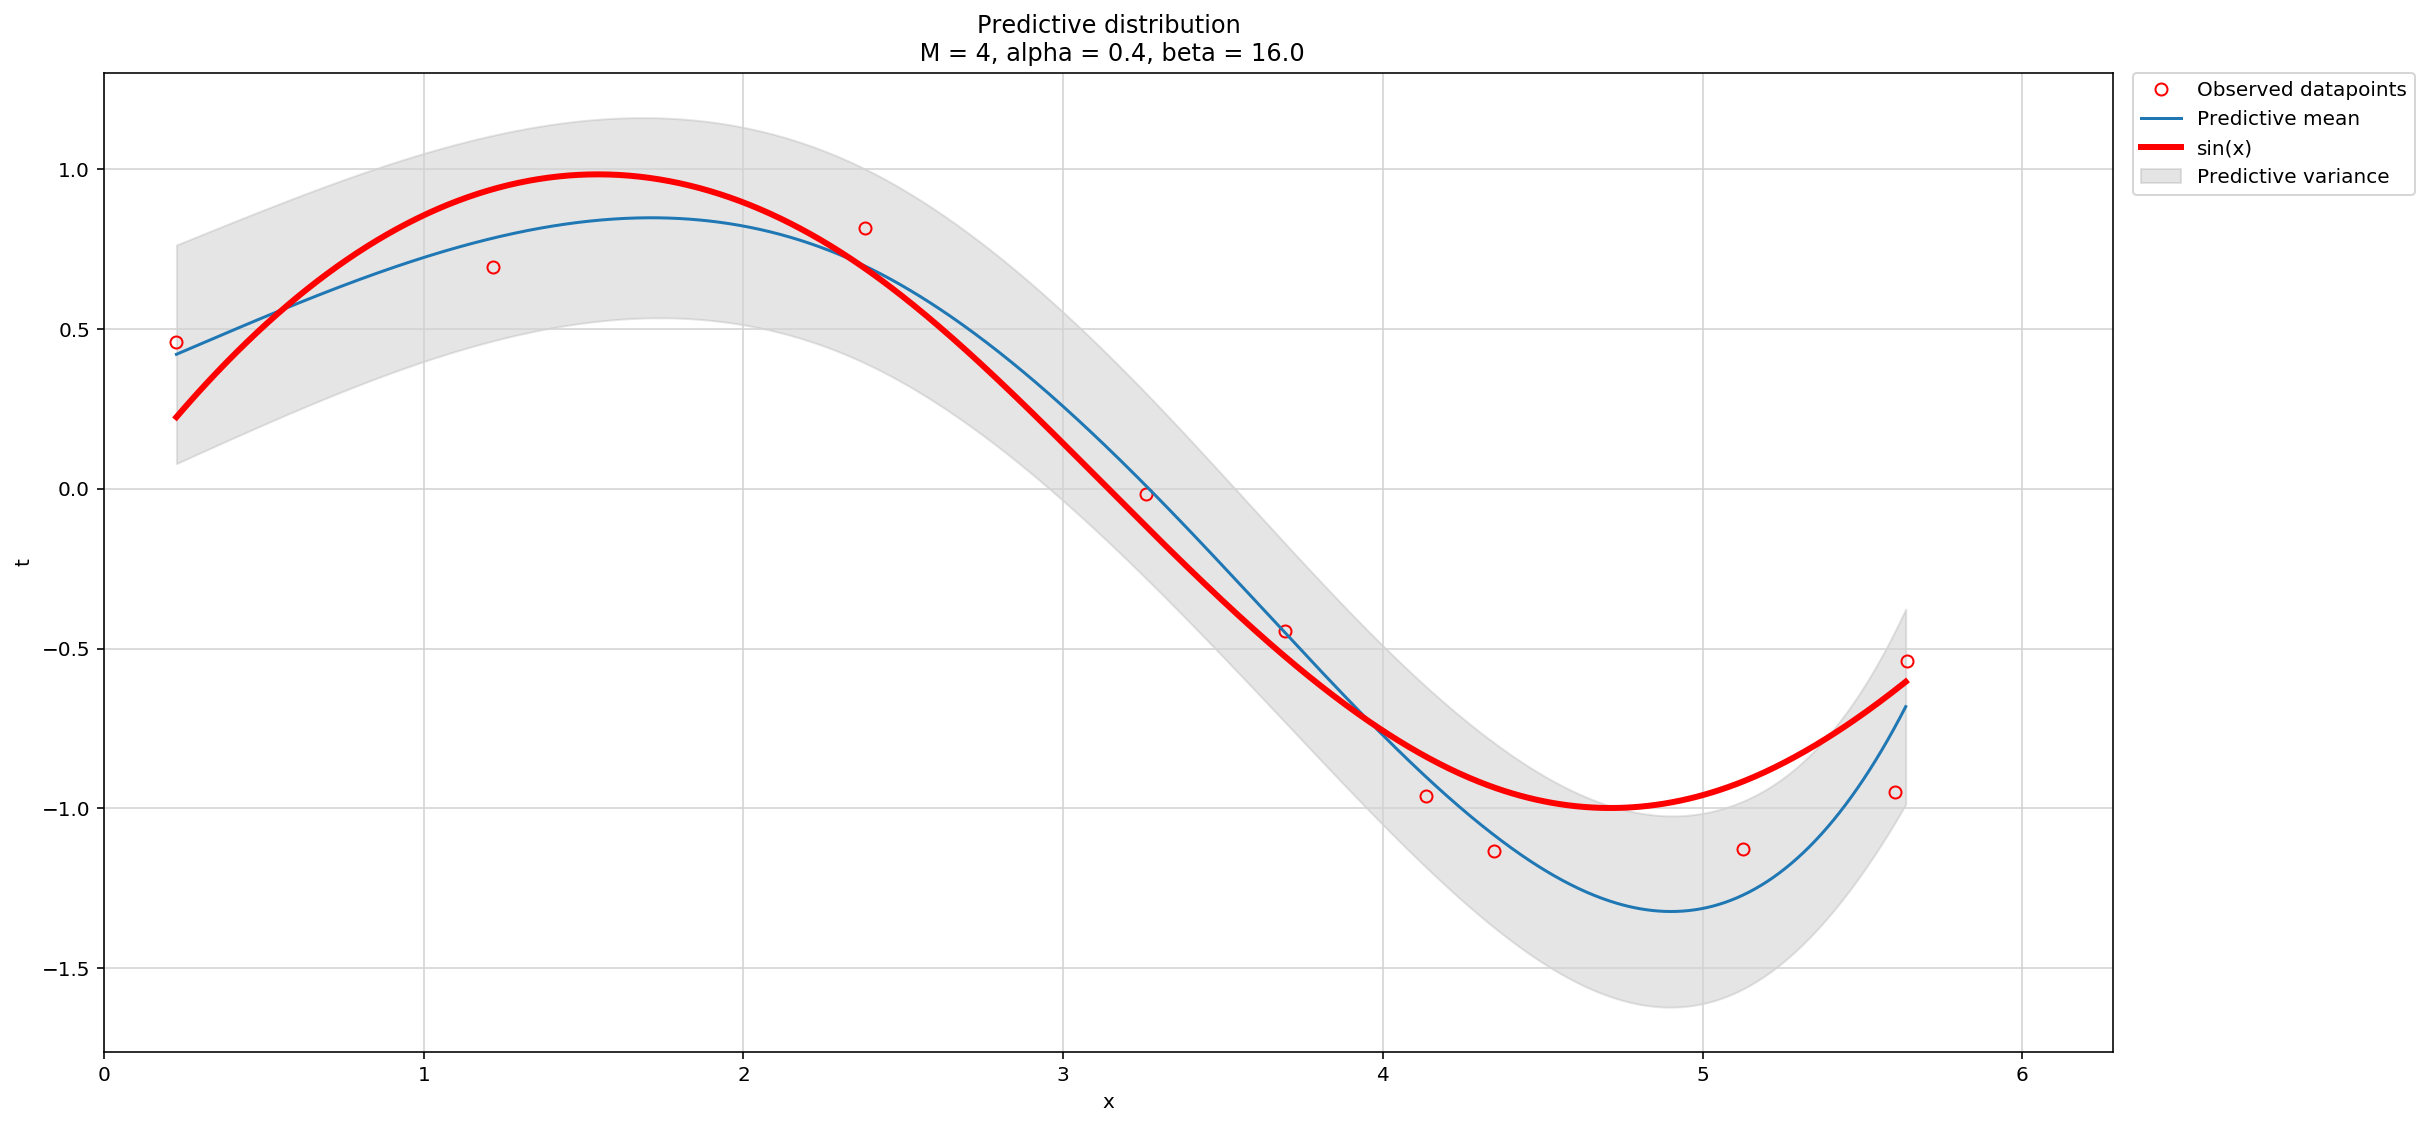

In [27]:
N = 10
M = 4
alpha = 2 / 5
beta = 1 / (0.25 ** 2)

np.random.seed(20)
x, t = gen_sine2(N)
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)
plot_predictive(x, t, m, S, beta, sin(x), "sin(x)")

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


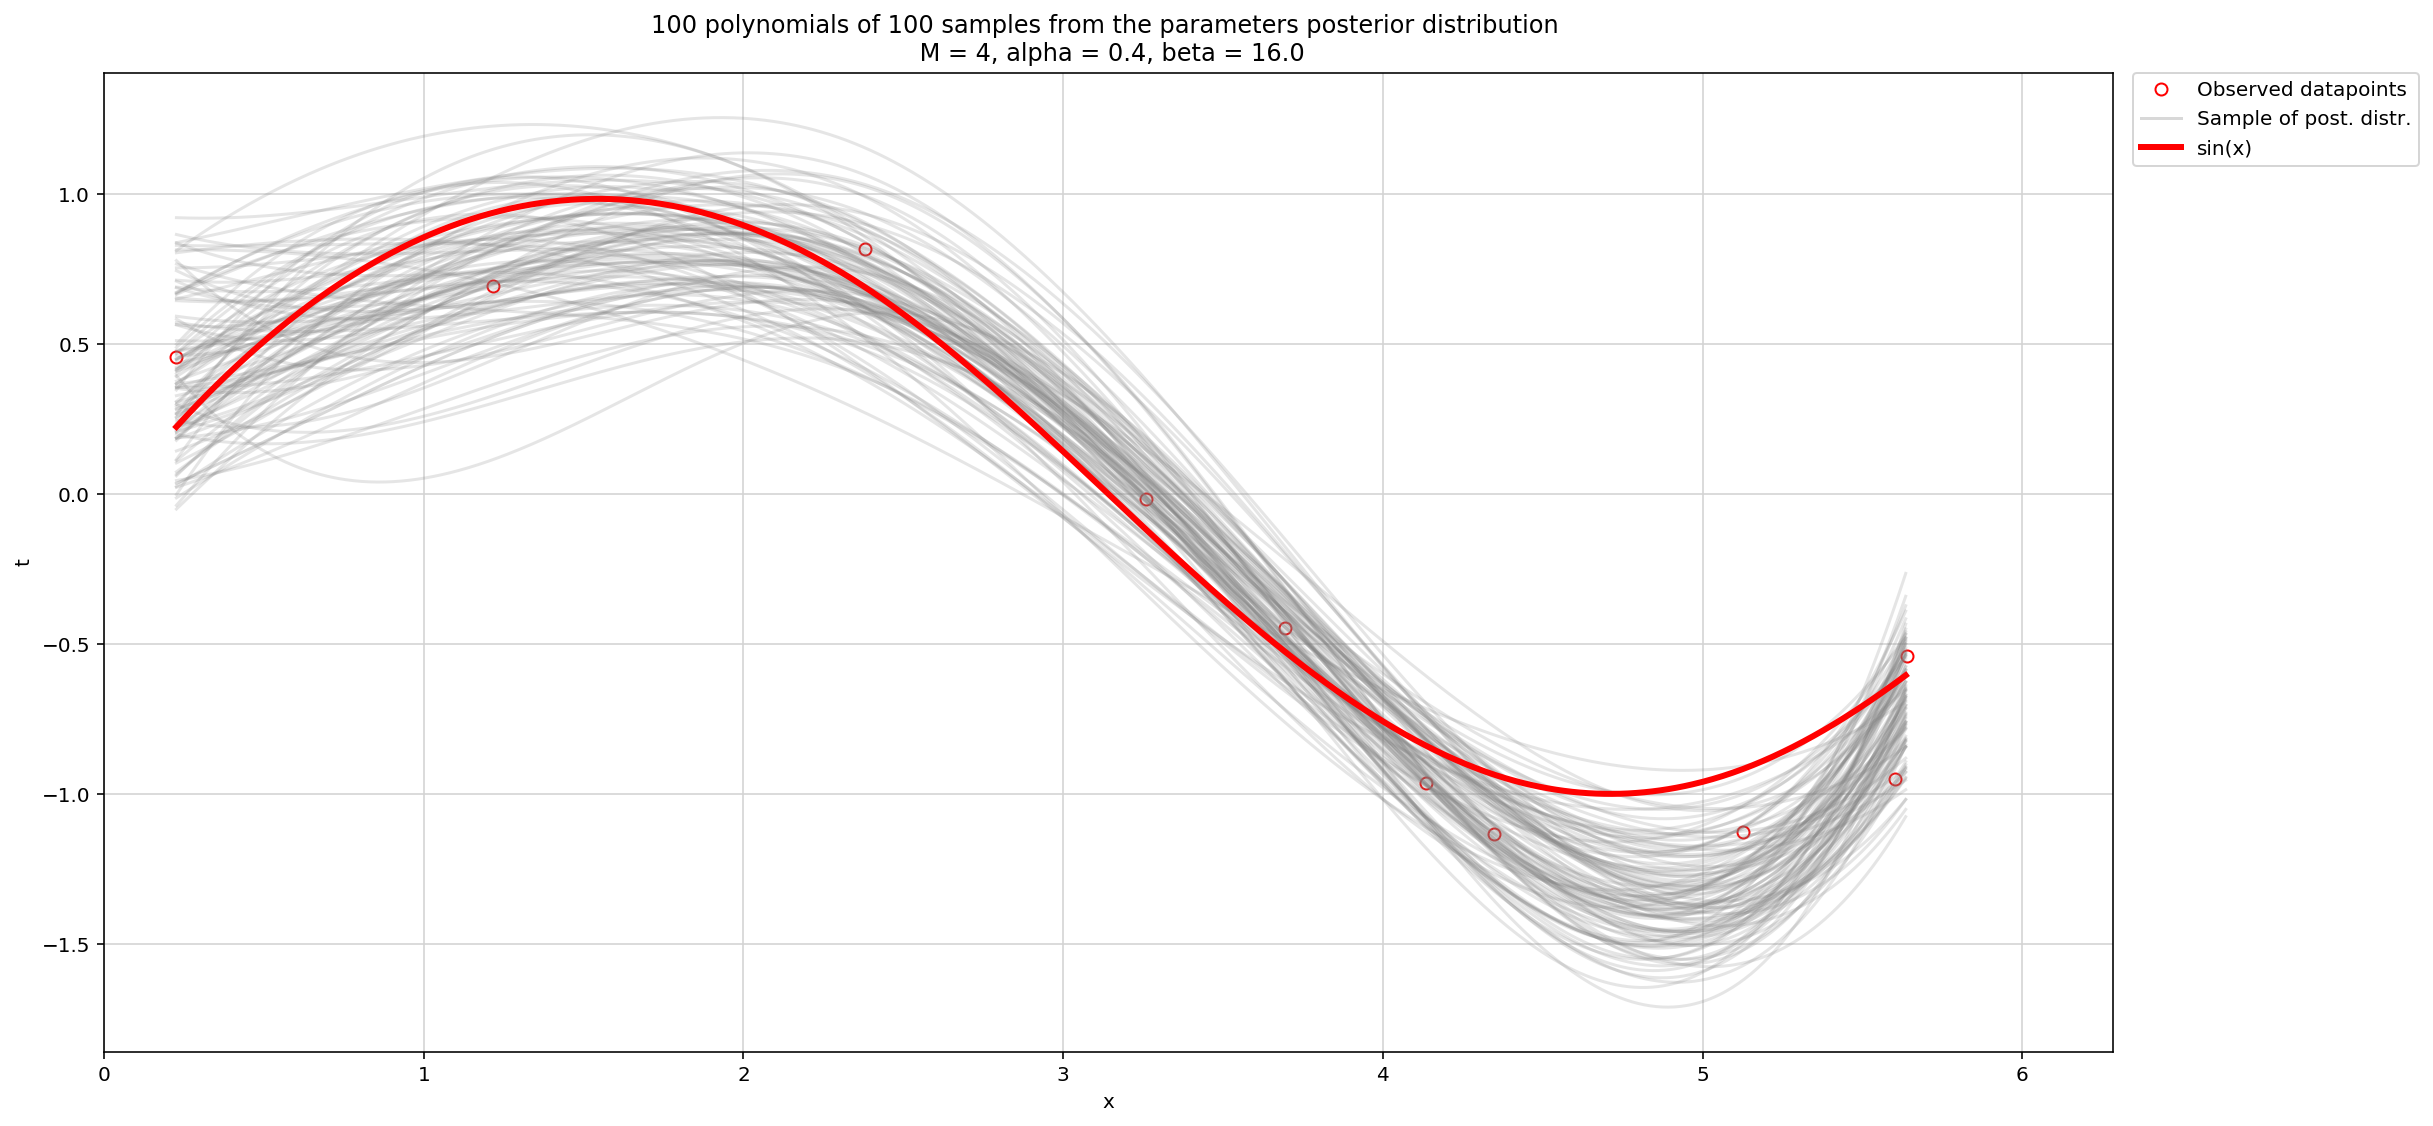

In [28]:
N = 10
M = 4
alpha = 2 / 5
beta = 1 / (0.25 ** 2)

np.random.seed(20)
x, t = gen_sine2(N)
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

plot_predictive(x, t, m, S, beta, sin(x), "sin(x)", True)

### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=\frac{1}{0.25^2}$ the best choice of $\beta$ in section 2.4?



$\frac{1}{\beta}$ represents the noise on the data in the variance of $\sigma^2_N(x)$ of the predictive distribution. Since we have produced the data ourselves, and the noise of the data is known to us, we can determine the optimal choice for $\frac{1}{\beta}$ which is equal to the variance of the noise. More formally,

$$\frac{1}{\beta} = 0.25^2 \Rightarrow $$
$$\beta = \frac{1}{0.25^2}$$

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

The choice of basis functions determines the possibilities of the resulting prediction models. Since they are chosen before fitting the data, one may choose the wrong set of basis functions.

Because of the range of possible prediction models represented by the chosen basis functions, it may incorrectly capture the real function that underlies the data. As a result, the model may represent the training data, but fail to predict new datapoints correctly.